In [1]:
import sys
sys.path.append("../../")

# Reproduction of Figure 3 using a GP model

Here I reproduce Figure 3 of Garnelo et al.'s article, using a Gaussian Process (GP) model instead of a Neural Process (NP). 
This mainly serves as a sanity check and a proof of concept for the general structure of my code.

In [2]:
import tensorflow as tf

from neuralprocesses.np.aux import DataProvider
from neuralprocesses.utils.gp import GaussianProcess
from neuralprocesses.utils.gp import squared_exponential_kernel

We sample functions from a GP with a squared-exponential kernel. For the latter, the correlation length is 2, and the other parameters are default values.

In [3]:
kernel = lambda x: squared_exponential_kernel(x, 2.)
distribution = lambda x: GaussianProcess((None, x), kernel, name="distr")

Now we construct the `DataProvider` module, which acts as an interface between the distribution and the model.

In [4]:
data_provider = DataProvider(distribution, batch_size=1, domain=(-2, 2))

The `data_provider` now generates `batch_size` example ground truth functions, sampled from the `distribution`.
The `data_for_plotting` property returns two lists of points.
The first list contains 100 uniformly random distributed x-coordinates and the corresponding y-values of the ground truth functions.
The second list contains 100 x-coordinates that are evenly spaced throughout the function domain and their corresponding y-values of the ground truth functions.
We name the two lists `context_points` and `target_points`, respectively.

In [5]:
data = data_provider.data

Like `context_points`, `target_points` is a tuple of two tensors: the x-coordinates and the y-values.
We will need both individually.

In [6]:
x_target = data.queries[1]
y_target = data.targets

# Repeat all target points SAMPLE_SIZE times
SAMPLE_SIZE = 5
x_target = tf.reshape(tf.transpose(tf.stack([x_target] * SAMPLE_SIZE), perm=[1, 0, 2]), (SAMPLE_SIZE, -1))
y_target = tf.reshape(tf.transpose(tf.stack([y_target] * SAMPLE_SIZE), perm=[1, 0, 2]), (SAMPLE_SIZE, -1))

# Transform to [B, n, 2] tensor, where n is the number of context points in each batch (good for plotting)
target_points = tf.transpose([x_target, y_target], perm=[1, 2, 0])

Randomly pick some context points.

In [7]:
r = tf.random_shuffle(tf.range(tf.shape(x_target)[1]))
x_context = tf.gather(x_target, r, axis=1)
y_context = tf.gather(y_target, r, axis=1)

# Transform to [B, n, 2] tensor, where n is the number of context points in each batch (good for plotting)
context_points = tf.transpose([x_context, y_context], perm=[1, 2, 0])

In contrast to the NP model, the GP model does not need to be trained, since we use the same kernel for data generation and for the model.
Thus, we create a GP model and provide it with a variable number of context points, as well as the `kernel` defined above.

In [8]:
model = GaussianProcess(((x_context, y_context), x_target), kernel, name="model")

In [9]:
# Transform to [B, n, 2] tensor, where n is the number of context points in each batch (good for plotting)
predictions = tf.transpose([x_target, model.sample], perm=[1, 2, 0])

For each ground truth, we now sample XXXX functions from the conditioned GP model and compare them visually to the ground truth function.

In [10]:
with tf.Session() as session:
    xc, yc, xt, yt = session.run(
        [x_context, y_context, x_target, y_target], 
        feed_dict={
            data_provider.plotting_mode: True
        })

In [17]:
with tf.Session() as session:
    p, t, c = session.run(
        [predictions, target_points, context_points], 
        feed_dict={
            x_context: xc[:,:2],
            y_context: yc[:,:2],
            x_target: xt,
            y_target: yt
        })

In [18]:
from neuralprocesses.utils.plotting import list_plot
from neuralprocesses.utils.plotting import Color
import numpy as np

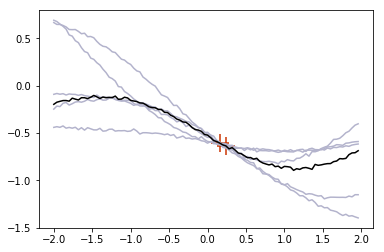

In [19]:
list_plot([p[0], p[1], p[2], p[3], p[4], t[0], c[0]], 
          joined=[True,True,True,True,True,True,False], 
          mesh=[False,False,False,False,False,False,True],
          plot_style=[
              Color((0.7,0.7,0.8)),  # Gray-blue samples from the GP model
              Color((0.7,0.7,0.8)),
              Color((0.7,0.7,0.8)),
              Color((0.7,0.7,0.8)),
              Color((0.7,0.7,0.8)),
              Color((0.,0.,0.)),     # Black ground truth
              {"Color": Color.color_data(n=0), "PointSize": 350, "Marker": "+"}  # Red crosses for context points
          ]
         )